# Forest Canopy Height - Inference

In [1]:
# Imports and Setup
import torch
import numpy as np
import matplotlib.pyplot as plt
from model import get_model
from Sentinel2DatasetClass import Sentinel2Dataset

/Users/michelleodnert/.pyenv/versions/3.11.5/lib/python3.11/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Load Test Dataset
test_dataset = Sentinel2Dataset(
    image_dir="data/processed/test",
    label_dir="data/processed/test",
    augment=False
)

print(f"Test dataset size: {len(test_dataset)}")

Test dataset size: 1000


In [3]:
# Load Trained Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model()

In [4]:
# Load the saved model state
checkpoint = torch.load('models/best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

print(f"Loaded model from epoch {checkpoint['epoch']} with validation loss: {checkpoint['val_loss']:.4f}")


Loaded model from epoch 14 with validation loss: 30.5157


/var/folders/w1/mt9g2b2n36qbnd1y0z2xj9qc0000gn/T/ipykernel_90003/2405541021.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('models/best_model.pt

In [5]:
# Define visualization function
def visualize_prediction(image, true_label, predicted_label, idx):
    """Visualize the input image, true label, and model prediction"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Display RGB image (bands 4,3,2 for Sentinel-2)
    rgb_bands = [3, 2, 1]  # Corresponding to R,G,B bands
    rgb_img = image[rgb_bands].numpy()
    rgb_img = np.transpose(rgb_img, (1, 2, 0))  # CHW to HWC
    rgb_normalized = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())
    
    axes[0].imshow(rgb_normalized)
    axes[0].set_title(f'Input Image {idx}')
    axes[0].axis('off')
    
    # Display true label
    im1 = axes[1].imshow(true_label, cmap='viridis')
    axes[1].set_title('True Canopy Height (m)')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1])
    
    # Display predicted label
    im2 = axes[2].imshow(predicted_label, cmap='viridis')
    axes[2].set_title('Predicted Canopy Height (m)')
    axes[2].axis('off')
    plt.colorbar(im2, ax=axes[2])
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    mae = np.mean(np.abs(true_label - predicted_label))
    rmse = np.sqrt(np.mean((true_label - predicted_label)**2))
    print(f"Mean Absolute Error: {mae:.2f} meters")
    print(f"Root Mean Square Error: {rmse:.2f} meters")

In [6]:
# Single Image Inference
def run_single_inference(idx=0):
    """Run inference on a single image from the test dataset"""
    image, true_label = test_dataset[idx]
    
    # Prepare input for model
    image = image.unsqueeze(0).to(device)  # Add batch dimension
    
    # Run inference
    with torch.no_grad():
        prediction = model(image)
        prediction = prediction.squeeze().cpu().numpy()
    
    # Convert true label to numpy for visualization
    true_label = true_label.numpy()
    
    # Visualize results
    visualize_prediction(image.squeeze().cpu(), true_label, prediction, idx)


In [7]:
# Multiple Image Inference
def run_multiple_inference(num_samples=3):
    """Run inference on multiple test images"""
    for idx in range(num_samples):
        image, true_label = test_dataset[idx]
        image = image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            prediction = model(image)
            prediction = prediction.squeeze().cpu().numpy()
        
        true_label = true_label.numpy()
        visualize_prediction(image.squeeze().cpu(), true_label, prediction, idx)
        print("\n" + "-"*50 + "\n")

Running inference on single image...


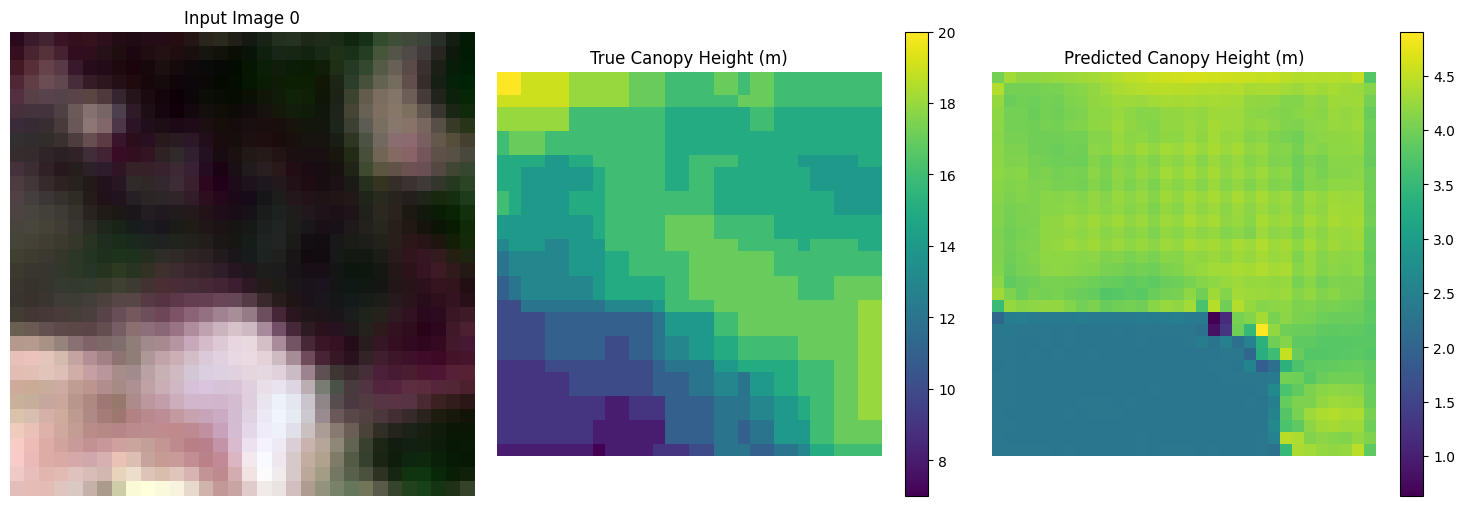

Mean Absolute Error: 10.74 meters
Root Mean Square Error: 10.95 meters

Running inference on multiple images...


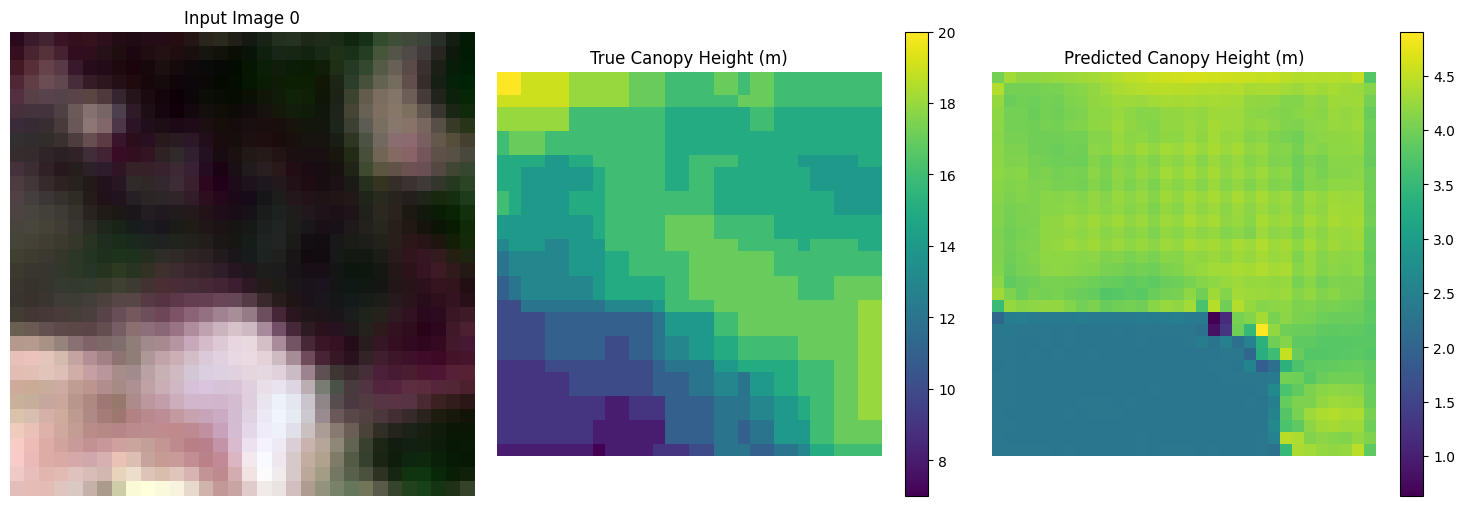

Mean Absolute Error: 10.74 meters
Root Mean Square Error: 10.95 meters

--------------------------------------------------



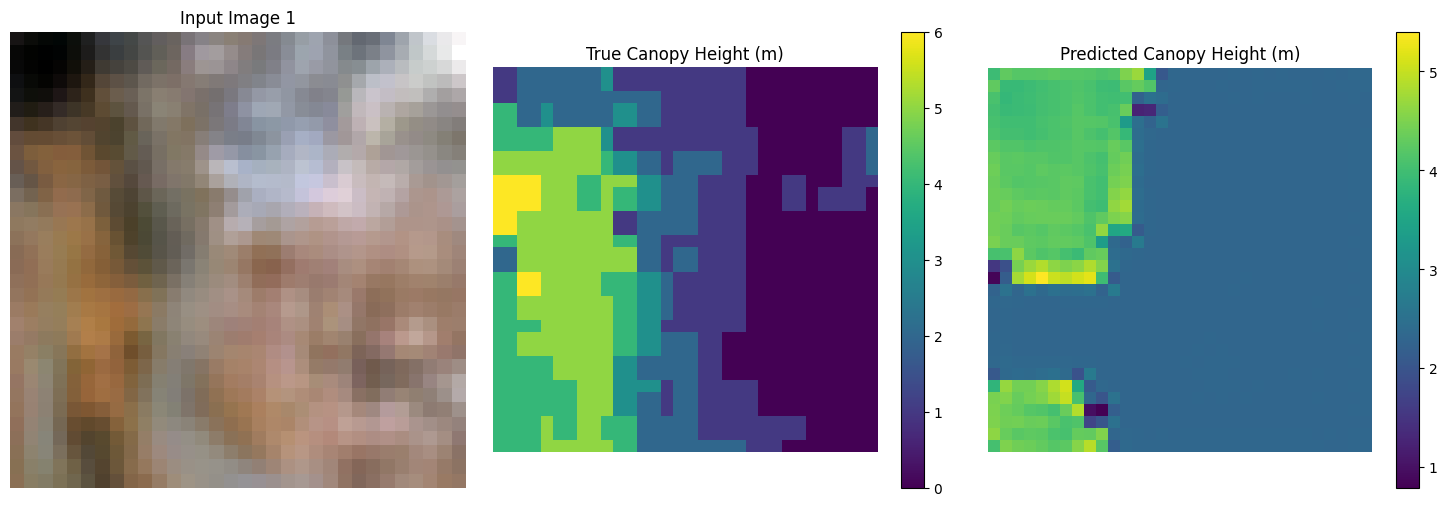

Mean Absolute Error: 1.56 meters
Root Mean Square Error: 1.78 meters

--------------------------------------------------



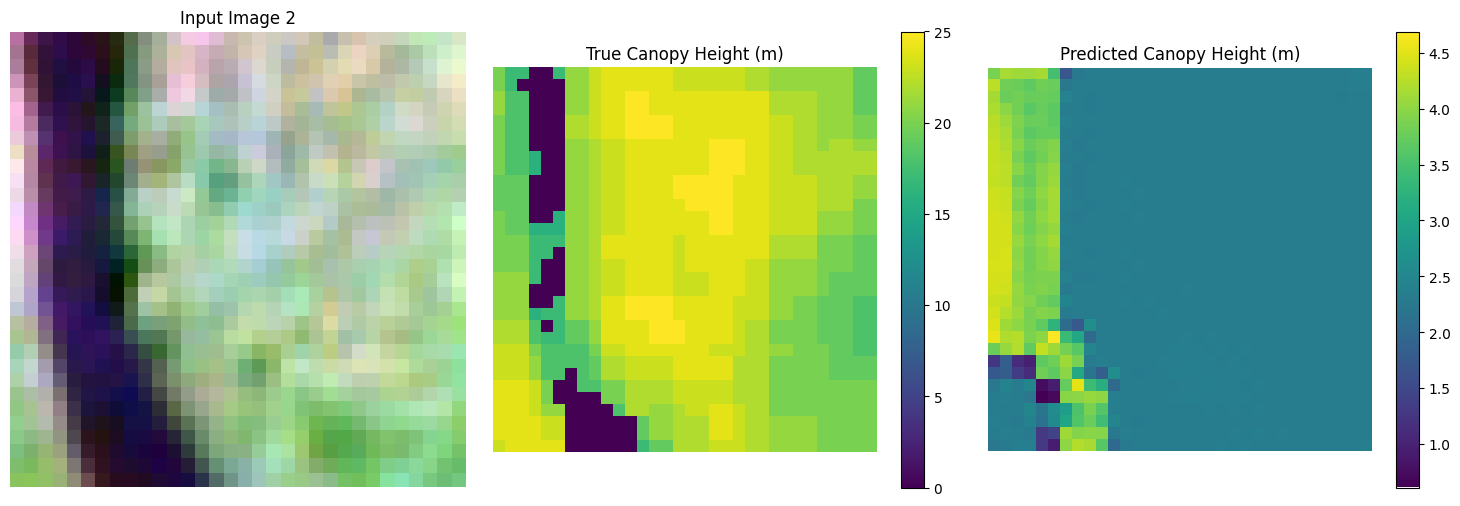

Mean Absolute Error: 18.25 meters
Root Mean Square Error: 18.86 meters

--------------------------------------------------



In [8]:
if __name__ == "__main__":
    # Run inference on a single image
    print("Running inference on single image...")
    run_single_inference(idx=0)
    
    # Run inference on multiple images
    print("\nRunning inference on multiple images...")
    run_multiple_inference(num_samples=3)